# Modeling using Boosters

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
%matplotlib inline

RANDOM_STATE = 42
class_names = ["A", "B", "None"]

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     print("Normalized confusion matrix")
    # else:
    #     print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
train_df = pd.read_csv("working_data/trial_promo_training.csv")
val_df = pd.read_csv("working_data/trial_promo_testing.csv")

print("train_df shape", train_df.shape)
print("val_df shape", val_df.shape)

train_df shape (850, 34)
val_df shape (150, 34)


### Data balancing using equal classes strategy

In [4]:
should_balance = True

In [5]:
number_of_nones = train_df[train_df["decision"] == "None"].shape[0]
nones_df = train_df[train_df["decision"] == "None"]
productA_df = train_df[train_df["decision"] == "A"]
productB_df = train_df[train_df["decision"] == "B"]
print("Number of None's: " + str(nones_df.shape[0]))
print("Increase product A's by: " + str(number_of_nones - productA_df.shape[0]))
print("Increase product B's by: " + str(number_of_nones - productB_df.shape[0]))
print("Number of product A's: " + str(productA_df.shape[0]))
print("Number of product B's: " + str(productB_df.shape[0]))
times_to_increase_productA_df = (number_of_nones - productA_df.shape[0])//productA_df.shape[0]
times_to_increase_productB_df = (number_of_nones - productB_df.shape[0])//productB_df.shape[0]

Number of None's: 704
Increase product A's by: 591
Increase product B's by: 671
Number of product A's: 113
Number of product B's: 33


In [6]:
if should_balance:
    repeated_product_A = [productA_df] * times_to_increase_productA_df
    repeated_product_B = [productB_df] * times_to_increase_productB_df
    repeated_product_A_df = pd.concat(repeated_product_A)
    repeated_product_B_df = pd.concat(repeated_product_B)
    dfs_to_concat = [nones_df, repeated_product_A_df, repeated_product_B_df]
    train_df = pd.concat(dfs_to_concat)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print("New # rows: " + str(train_df.shape[0]))
    train_df.head()
else:
    print("Training data will not be balanced")

New # rows: 1929


In [7]:
features_to_scale = ["age", "income", "avbal", "avtrans"]
min_max_scaler = preprocessing.MinMaxScaler()
train_df[features_to_scale] = min_max_scaler.fit_transform(train_df[features_to_scale])

train_df.head()

,age,income,avbal,avtrans,decision,sexNum,mstatusNum,occupationNum,educationNum,childrenNum,...,occupation_retired,education_postgrad,education_professional,education_secondary,education_tertiary,children_0,children_1,children_2,children_3,children_4
0,0.349847,0.210906,0.281154,0.151817,None,1,0,4,3,0,...,0,0,0,0,1,1,0,0,0,0
1,0.166156,0.038794,0.309330,0.222713,None,0,2,5,2,0,...,0,0,0,1,0,1,0,0,0,0
2,0.041191,0.600271,0.678186,0.214756,B,0,2,4,1,0,...,0,0,1,0,0,1,0,0,0,0
3,0.853465,0.055383,0.117837,0.133335,None,0,3,8,2,2,...,1,0,0,1,0,0,0,1,0,0
4,0.131088,0.413109,0.573015,0.423616,B,1,0,6,0,3,...,0,1,0,0,0,0,0,0,1,0


In [8]:
val_df[features_to_scale] = min_max_scaler.transform(val_df[features_to_scale])
val_df.head()

,age,income,avbal,avtrans,decision,sexNum,mstatusNum,occupationNum,educationNum,childrenNum,...,occupation_retired,education_postgrad,education_professional,education_secondary,education_tertiary,children_0,children_1,children_2,children_3,children_4
0,0.543279,0.650859,0.375240,0.239193,None,1,0,3,0,1,...,0,1,0,0,0,0,1,0,0,0
1,0.565127,0.239707,0.123624,0.173393,None,1,3,4,3,0,...,0,0,0,0,1,1,0,0,0,0
2,0.307821,0.037887,0.193715,0.143784,A,0,1,3,2,0,...,0,0,0,1,0,1,0,0,0,0
3,0.247286,0.556982,0.424065,0.942380,A,0,1,3,1,1,...,0,0,1,0,0,0,1,0,0,0
4,0.258280,0.060213,0.149547,0.093710,None,0,0,4,2,1,...,0,0,0,1,0,0,1,0,0,0


In [9]:
feature_columns = ["age", "income", "avbal", "avtrans", "sexNum", "mstatusNum", "occupationNum", "educationNum", "childrenNum"]
target_column = ["decision"]
X_train = train_df.loc[:, feature_columns]
y_train = train_df[target_column].replace("A", 0).replace("B", 1).replace("None", 2)
X_val = val_df.loc[:, feature_columns]
y_val = val_df[target_column].replace("A", 0).replace("B", 1).replace("None", 2)
X_train.head(5)

,age,income,avbal,avtrans,sexNum,mstatusNum,occupationNum,educationNum,childrenNum
0,0.349847,0.210906,0.281154,0.151817,1,0,4,3,0
1,0.166156,0.038794,0.309330,0.222713,0,2,5,2,0
2,0.041191,0.600271,0.678186,0.214756,0,2,4,1,0
3,0.853465,0.055383,0.117837,0.133335,0,3,8,2,2
4,0.131088,0.413109,0.573015,0.423616,1,0,6,0,3


## AdaBoost

In [10]:
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE), learning_rate=0.1, algorithm="SAMME.R", n_estimators=50, random_state=RANDOM_STATE)

In [11]:
adaboost.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          learning_rate=0.1, n_estimators=50, random_state=42)

In [12]:
y_pred_ada = adaboost.predict(X_val)

In [13]:
adaboost_features_importance = adaboost.feature_importances_

list = []
i = 0
for importance in adaboost_features_importance:
    list.append({"name": X_train.columns[i], "importance": importance})
    i += 1

importance_df = pd.DataFrame(list)
importance_df.sort_values(by=['importance'], ascending=[False])

,importance,name
5,0.934160,mstatusNum
0,0.033022,age
1,0.024712,income
2,0.004849,avbal
3,0.003257,avtrans
4,0.000000,sexNum
6,0.000000,occupationNum
7,0.000000,educationNum
8,0.000000,childrenNum


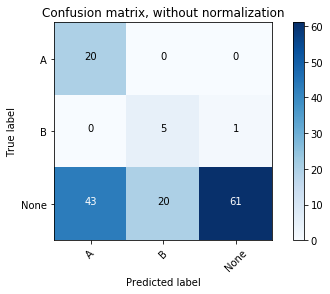

In [14]:
cnf_matrix_ada = confusion_matrix(y_val, y_pred_ada)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_ada, classes=class_names,
                      title='Confusion matrix, without normalization')

In [15]:
print("test accuracy:", accuracy_score(y_val, y_pred_ada))

test accuracy: 0.5733333333333334


In [16]:
print("kappa score:", cohen_kappa_score(y_val, y_pred_ada))

kappa score: 0.283689001641546


In [17]:
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_pred_ada, labels=[0,1,2])
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=class_names)
score_df

,precision,recall,f1-score,support
A,0.3175,1.0000,0.4819,20
B,0.2000,0.8333,0.3226,6
None,0.9839,0.4919,0.6559,124


In [18]:
import pickle

# save model to file
pickle.dump(adaboost, open("models/adaboost_kappa_0_2836.pickle.dat", "wb"))

## Gradient Boosting

In [19]:
gradientboost = GradientBoostingClassifier(n_estimators=50, max_leaf_nodes=5, max_depth=2, random_state=RANDOM_STATE, min_samples_split=5)

In [20]:
gradientboost.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=5,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=5,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [21]:
y_pred_grad = adaboost.predict(X_val)

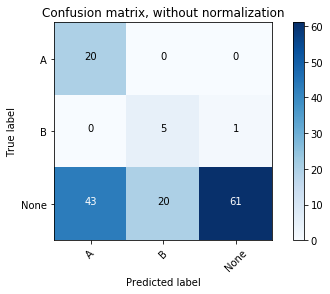

In [22]:
cnf_matrix_grad = confusion_matrix(y_val, y_pred_grad)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_grad, classes=class_names,
                      title='Confusion matrix, without normalization')

In [23]:
print("test accuracy:", accuracy_score(y_val, y_pred_grad))

test accuracy: 0.5733333333333334


In [24]:
print("kappa score:", cohen_kappa_score(y_val, y_pred_grad))

kappa score: 0.283689001641546


In [25]:
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_pred_grad, labels=[0,1,2])
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=class_names)
score_df

,precision,recall,f1-score,support
A,0.3175,1.0000,0.4819,20
B,0.2000,0.8333,0.3226,6
None,0.9839,0.4919,0.6559,124


## XGBoost

In [26]:
# selected_features = ["avtrans", "avbal", "age", "income", "mstatusNum"]
selected_features = ["age", "income", "avbal", "avtrans", "sexNum", "mstatusNum", "occupationNum", "educationNum", "childrenNum"]

X_train_xgb = X_train.loc[:, selected_features]
X_val_xgb = X_val.loc[:, selected_features]

X_train_xgb.head(5)

,age,income,avbal,avtrans,sexNum,mstatusNum,occupationNum,educationNum,childrenNum
0,0.349847,0.210906,0.281154,0.151817,1,0,4,3,0
1,0.166156,0.038794,0.309330,0.222713,0,2,5,2,0
2,0.041191,0.600271,0.678186,0.214756,0,2,4,1,0
3,0.853465,0.055383,0.117837,0.133335,0,3,8,2,2
4,0.131088,0.413109,0.573015,0.423616,1,0,6,0,3


In [27]:
bst = xgb.XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=20, booster='dart', base_score=0.5, random_state=RANDOM_STATE)
bst.fit(X_train_xgb, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [28]:
y_pred_xgb = bst.predict(X_val_xgb)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [29]:
xgboost_features_importance = bst.feature_importances_

list = []
i = 0
for importance in xgboost_features_importance:
    list.append({"name": X_train_xgb.columns[i], "importance": importance})
    i += 1

importance_df = pd.DataFrame(list)
importance_df.sort_values(by=['importance'], ascending=[False])

,importance,name
5,0.478571,mstatusNum
0,0.278571,age
1,0.171429,income
2,0.050000,avbal
8,0.014286,childrenNum
6,0.007143,occupationNum
3,0.000000,avtrans
4,0.000000,sexNum
7,0.000000,educationNum


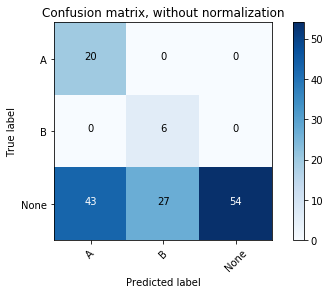

In [30]:
cnf_matrix_grad = confusion_matrix(y_val, y_pred_xgb)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_grad, classes=class_names,
                      title='Confusion matrix, without normalization')

In [31]:
print("test accuracy:", accuracy_score(y_val, y_pred_xgb))

test accuracy: 0.5333333333333333


In [32]:
print("kappa score:", cohen_kappa_score(y_val, y_pred_xgb))

kappa score: 0.2680886658301965


In [33]:
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_pred_xgb, labels=[0,1,2])
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=class_names)
score_df

,precision,recall,f1-score,support
A,0.3175,1.0000,0.4819,20
B,0.1818,1.0000,0.3077,6
None,1.0000,0.4355,0.6067,124


In [34]:
import pickle

# save model to file
pickle.dump(bst, open("models/xgboost_kappa_0_2680.pickle.dat", "wb"))

# Use Model to predict

In [35]:
model = pickle.load(open("models/xgboost_kappa_0_2680.pickle.dat", "rb"))

In [36]:
df = pd.read_csv("original_data/cust_actual_merged.csv")
df.head(5)

,index,sex,mstatus,age,children,occupation,education,income,avbal,avtrans,status,score
0,1001,M,divorced,44.27,2,legal,postgrad,10245.73,53183.04,4069.67,None,5.2
1,1002,M,married,61.90,1,legal,secondary,1942.57,18100.78,1522.42,None,2.5
2,1003,M,divorced,37.30,1,IT,tertiary,9896.16,24496.82,2723.35,None,4.1
3,1004,F,divorced,25.02,1,legal,postgrad,10136.44,26690.01,4143.04,None,4.4
4,1005,F,divorced,48.37,2,government,secondary,2521.11,13439.81,240.26,None,2.3


In [37]:
# strip the spaces in the header, if present
df = df.rename(columns=lambda x: x.strip())
df.columns.values

array(['index', 'sex', 'mstatus', 'age', 'children', 'occupation',
       'education', 'income', 'avbal', 'avtrans', 'status', 'score'],
      dtype=object)

In [38]:
categorical_features = ["sex", "mstatus", "occupation", "education", "children"]
df[categorical_features].head()
df["children"] = df["children"].astype(str)
label_encoders = {}
label_mappings = {}
for categorical_feature in categorical_features:
    label_encoders[categorical_feature] = preprocessing.LabelEncoder()
    df[categorical_feature + "Num"] = label_encoders[categorical_feature].fit_transform(df[categorical_feature])
    label_mappings[categorical_feature] = label_encoders[categorical_feature].classes_

label_encoders = {}
label_mappings = {}
for categorical_feature in categorical_features:
    label_encoders[categorical_feature] = preprocessing.LabelEncoder()
    df[categorical_feature + "Num"] = label_encoders[categorical_feature].fit_transform(df[categorical_feature])
    label_mappings[categorical_feature] = label_encoders[categorical_feature].classes_

for categorical_feature in categorical_features:
    for class_value in label_mappings[categorical_feature]:
        df[categorical_feature + "_" + (class_value)] = df[categorical_feature] == np.array([(class_value)] * df.shape[0])
        df[categorical_feature + "_" + (class_value)] = df[categorical_feature + "_" + (class_value)].astype(int)

# drop the categorical values
df = df.drop(categorical_features, axis=1)

train_df = pd.read_csv("working_data/trial_promo_training.csv")

features_to_scale = ["age", "income", "avbal", "avtrans"]
min_max_scaler = preprocessing.MinMaxScaler()

# fit on the train data
train_df[features_to_scale] = min_max_scaler.fit(train_df[features_to_scale])

# transform the test data
df[features_to_scale] = min_max_scaler.transform(df[features_to_scale])
df.head()

customer_ids = df["index"]
df = df.drop("index", axis=1)
df.head()

,age,income,avbal,avtrans,status,score,sexNum,mstatusNum,occupationNum,educationNum,...,occupation_retired,education_postgrad,education_professional,education_secondary,education_tertiary,children_0,children_1,children_2,children_3,children_4
0,0.364876,0.510499,0.675107,0.497236,None,5.2,1,0,5,0,...,0,1,0,0,0,0,0,1,0,0
1,0.610214,0.081311,0.222841,0.182472,None,2.5,1,1,5,2,...,0,0,0,1,0,0,1,0,0,0
2,0.267882,0.492430,0.305296,0.330871,None,4.1,1,0,0,3,...,0,0,0,0,1,0,1,0,0,0
3,0.096994,0.504850,0.333570,0.506303,None,4.4,0,0,5,0,...,0,1,0,0,0,0,1,0,0,0
4,0.421932,0.111215,0.162754,0.024034,None,2.3,0,0,4,2,...,0,0,0,1,0,0,0,1,0,0


In [39]:
feature_columns = ["age", "income", "avbal", "avtrans", "sexNum", "mstatusNum", "occupationNum", "educationNum", "childrenNum"]
target_column = ["status"]
X_test = df.loc[:, feature_columns]
y_test = df[target_column].replace("A", 0).replace("B", 1).replace("None", 2)
X_test.head(5)

,age,income,avbal,avtrans,sexNum,mstatusNum,occupationNum,educationNum,childrenNum
0,0.364876,0.510499,0.675107,0.497236,1,0,5,0,2
1,0.610214,0.081311,0.222841,0.182472,1,1,5,2,1
2,0.267882,0.492430,0.305296,0.330871,1,0,0,3,1
3,0.096994,0.504850,0.333570,0.506303,0,0,5,0,1
4,0.421932,0.111215,0.162754,0.024034,0,0,4,2,2


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


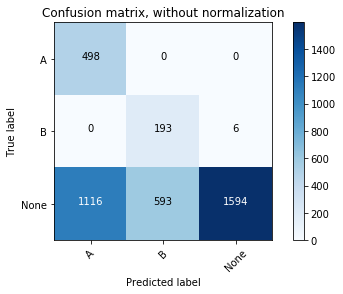

In [40]:
y_test_pred = model.predict(X_test)

cnf_matrix_grad = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_grad, classes=class_names,
                      title='Confusion matrix, without normalization')

In [41]:
print("test accuracy:", accuracy_score(y_test, y_test_pred))
print("kappa score:", cohen_kappa_score(y_test, y_test_pred))

test accuracy: 0.57125
kappa score: 0.2967718959706259


In [42]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_test_pred, labels=[0,1,2])
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=class_names)
score_df

,precision,recall,f1-score,support
A,0.3086,1.0000,0.4716,498
B,0.2455,0.9698,0.3919,199
None,0.9962,0.4826,0.6502,3303
